In [1]:
# python
import os, sys, pickle
from collections import OrderedDict
from itertools import combinations_with_replacement

# stats
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from scipy.stats import pearsonr, spearmanr


# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# thesis library
from lib.functions_base_analysis import *
from lib.functions_second_analysis import *
from lib.ImageDataset import ImageDataset
from lib.NetworkScorer import NetworkScorer
from lib.PatternGenerator import Pattern_Generator
from lib.ActivationPattern import Activation_Pattern
from lib.transforms import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight import PatternGeneratorSearchlight

DATASET_NAMES = ("places1", "places2", "oasis")
SCALE_NAMES = ("scale2", "scale4", "scale8", "scale16", "scale32")
STUDY_NAMES = ("short presentation", "long presentation", "complexity order", "oasis")
BEHAVIOUR_NAMES = (
    "study1_places1_short.csv",
    "study2_places1.csv",
    "study3_places2.csv",
    "study4_oasis.csv",
)

PATH_IMAGES = "../images and ratings/imageversions_256"
PATH_RATINGS = "../images and ratings/ratings"
PATH_INTEGRATION = (
    "../data csv/integration"  # !! correlations, invert sign for integration
)
PATH_INTEGRATION_BLOCKED = (
    "../data csv/integration blocked"  # !! correlations, invert sign for integration
)
PATH_IBCORR = "../data csv/ibcorr"
PATH_IBCORR_UNBLOCKED_INT = "../data csv/ibcorr unblocked_int"
PATH_IBCORR_BLOCKED_INT = "../data csv/ibcorr blocked_int"


PATH_RESULTS = "../results"
PATH_PLOTS = "../plots"

# VisualPrior.viable_feature_tasks
MODEL_NAMES = (
    "autoencoding",
    "depth_euclidean",
    "jigsaw",
    "reshading",
    "edge_occlusion",
    "keypoints2d",
    "room_layout",  #'colorization' currently not working
    "curvature",
    "edge_texture",
    "keypoints3d",
    "segment_unsup2d",
    "class_object",
    "egomotion",
    "nonfixated_pose",
    "segment_unsup25d",
    "class_scene",
    "fixated_pose",
    "normal",
    "segment_semantic",
    "denoising",
    "inpainting",
    "point_matching",
    "vanishing_point",
)

# uniform blocking across this script to avoid bugs
BLOCKING_GROUPS = np.insert(np.repeat(range(1, 16 + 1), 3), 0, 0)

# create folder structure

In [ ]:
# create folder structure for imageversions
for dataset_name in DATASET_NAMES:
    for scale_name in SCALE_NAMES:
        for version_name in ("full", "version1", "version2"):
            os.makedirs(
                os.path.join(PATH_IMAGES, dataset_name, scale_name, version_name)
            )

## data csv

In [462]:
# integration
for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:
            dir_path = os.path.join(
                PATH_INTEGRATION_BLOCKED, model_name, dataset_name, scale_name
            )
            os.makedirs(dir_path)

In [49]:
# ibcorr
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            os.makedirs(
                os.path.join(
                    PATH_IBCORR_BLOCKED_INTEGR, model_name, study_name, scale_name
                )
            )

## data mat

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "ibcorr", model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "ibcorr blocked", model_name))

In [488]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "ibcorr blocked_integr", model_name))

In [484]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "integration", model_name))

In [ ]:
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join("../data mat", "integration blocked", model_name))

# main analysis: part-whole correlations taskonomy 

In [ ]:
for model_name in MODEL_NAMES:
    print(model_name)

    # Import taskonomy model...
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    # ...and create activation extractor from it
    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node: node for node in eval_nodes if "conv" in node or "fc" in node}
    activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)

    for dataset_name in DATASET_NAMES:
        print(dataset_name)

        for scale_name in SCALE_NAMES:

            dataset = ImageDataset(os.path.join(PATH_IMAGES, dataset_name, scale_name))

            correlations, selfsimilarity, l2norm = calculate_dataset_metrics(
                dataset, activation_extractor
            )

            correlations.fillna(correlations.mean())
            selfsimilarity.fillna(selfsimilarity.mean())
            l2norm.fillna(l2norm.mean())

            correlations.to_csv(
                os.path.join(
                    PATH_INTEGRATION,
                    model_name,
                    dataset_name,
                    scale_name,
                    "correlations.csv",
                ),
                index=False,
                header=False,
            )
            selfsimilarity.to_csv(
                os.path.join(
                    PATH_INTEGRATION,
                    model_name,
                    dataset_name,
                    scale_name,
                    "selfsimilarity.csv",
                ),
                index=False,
                header=False,
            )
            l2norm.to_csv(
                os.path.join(
                    PATH_INTEGRATION, model_name, dataset_name, scale_name, "l2norm.csv"
                ),
                index=False,
                header=False,
            )

# integration

## load unblocked

In [2]:
# load integration, selfsim and l2norm
cl, sl, nl = [], [], []


for mo in MODEL_NAMES:
    for da in DATASET_NAMES:
        for sc in SCALE_NAMES:

            c = (
                pd.read_csv(
                    os.path.join(PATH_INTEGRATION, mo, da, sc, "correlations.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )

            s = (
                pd.read_csv(
                    os.path.join(PATH_INTEGRATION, mo, da, sc, "selfsimilarity.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )

            n = (
                pd.read_csv(
                    os.path.join(PATH_INTEGRATION, mo, da, sc, "l2norm.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )

            cl.append(c)
            sl.append(s)
            nl.append(n)

# convert correlation to integration
dfi = -pd.concat(cl).set_index(["model", "dataset", "scale", "img"])
dfs = pd.concat(sl).set_index(["model", "dataset", "scale", "img"])
dfn = pd.concat(nl).set_index(["model", "dataset", "scale", "img"])

## block unblocked
block layers accoring to vgg50 inherent blocks

In [ ]:
dfi_b = dfi.T.set_index(BLOCKING_GROUPS).T.groupby(level=0, axis=1).mean().sort_index()
dfs_b = dfs.T.set_index(BLOCKING_GROUPS).T.groupby(level=0, axis=1).mean().sort_index()
dfn_b = dfn.T.set_index(BLOCKING_GROUPS).T.groupby(level=0, axis=1).mean().sort_index()

## save blocked 


In [ ]:
# correlation, selfsim, l2norm
for m in MODEL_NAMES:
    for d in DATASET_NAMES:
        for sc in SCALE_NAMES:
            dfc_b = -dfi_b  # save as correlation, not integration
            dfc_b.loc[(m, d, sc), :].to_csv(
                os.path.join(PATH_INTEGRATION_BLOCKED, m, d, sc, "correlations.csv"),
                index=False,
                header=False,
            )
            dfs_b.loc[(m, d, sc), :].to_csv(
                os.path.join(PATH_INTEGRATION_BLOCKED, m, d, sc, "selfsimilarity.csv"),
                index=False,
                header=False,
            )
            dfn_b.loc[(m, d, sc), :].to_csv(
                os.path.join(PATH_INTEGRATION_BLOCKED, m, d, sc, "l2norm.csv"),
                index=False,
                header=False,
            )

## load blocked

In [3]:
# load correlation, selfsim and l2norm
cl, sl, nl = [], [], []


for mo in MODEL_NAMES:
    for da in DATASET_NAMES:
        for sc in SCALE_NAMES:

            c = (
                pd.read_csv(
                    os.path.join(
                        PATH_INTEGRATION_BLOCKED, mo, da, sc, "correlations.csv"
                    ),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )

            s = (
                pd.read_csv(
                    os.path.join(
                        PATH_INTEGRATION_BLOCKED, mo, da, sc, "selfsimilarity.csv"
                    ),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )

            n = (
                pd.read_csv(
                    os.path.join(PATH_INTEGRATION_BLOCKED, mo, da, sc, "l2norm.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )

            cl.append(c)
            sl.append(s)
            nl.append(n)

# convert correlation to integration
dfi_b = -pd.concat(cl).set_index(["model", "dataset", "scale", "img"])
dfs_b = pd.concat(sl).set_index(["model", "dataset", "scale", "img"])
dfn_b = pd.concat(nl).set_index(["model", "dataset", "scale", "img"])

## visualize

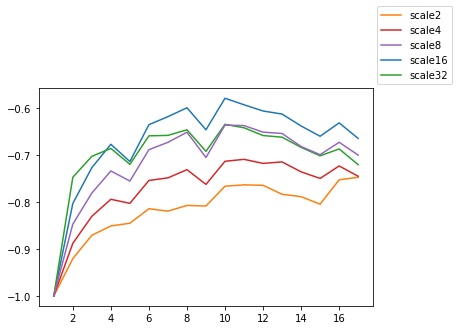

In [ ]:
handles, labels = (
    dfc_b.groupby("scale").mean().transpose().plot().get_legend_handles_labels()
)
order = [1, 3, 4, 0, 2]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    bbox_to_anchor=(1.25, 1.4),
)

# ibcorr & pvalues

## load ibcorr

### unblocked

In [4]:
# ib_list, ss_list, ibss_list = [],[],[]

# THIS IMPORT METHOD IS MORE EFFICIENT THAN METHOD USED IN BLOCKD IBCORR

ib_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            ib = pd.read_csv(
                os.path.join(
                    PATH_IBCORR,
                    model_name,
                    study_name,
                    scale_name,
                    "ib_correlations.csv",
                ),
                header=None,
            ).transpose()
            ib.insert(0, "scale", scale_name)
            ib.insert(0, "study", study_name)
            ib.insert(0, "model", model_name)
            ib_list.append(ib)
            # ss = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'self_similarity.csv'), header=None).transpose()
            # ss.insert(0, 'scale', scale_name)
            # ss.insert(0, 'study',study_name)
            # ss.insert(0, 'model', model_name)
            # ss_list.append(ss)
            # ibss = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, model_name, study_name, scale_name, 'ib_correlation_ss_partialed.csv'), header=None).transpose()
            # ibss.insert(0, 'scale', scale_name)
            # ibss.insert(0, 'study',study_name)
            # ibss.insert(0, 'model', model_name)
            # ibss_list.append(ibss)
df_ibcorr = pd.concat(ib_list).set_index(["model", "study", "scale"])
# ss_df = pd.concat(ss_list).set_index(['model','study','scale'])
# ibss_df = pd.concat(ibss_list).set_index(['model','study','scale'])

### blocked; from unblocked integration

In [5]:
ib_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            ib = pd.read_csv(
                os.path.join(
                    PATH_IBCORR_UNBLOCKED_INT,
                    model_name,
                    study_name,
                    scale_name,
                    "ib_correlations.csv",
                ),
                header=None,
            )  # .transpose()
            ib.insert(0, "scale", scale_name)
            ib.insert(0, "study", study_name)
            ib.insert(0, "model", model_name)
            ib_list.append(ib)

# add layer labels
ib_list = [ib.reset_index().rename(columns={"index": "layer"}) for ib in ib_list]

# combine into one DataFrame
df_ibcorr_b_ubi = (
    pd.concat(ib_list)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "layer"])
)

# sort indices
df_ibcorr_b_ubi = df_ibcorr_b_ubi.unstack("layer")
df_ibcorr_b_ubi.columns = df_ibcorr_b_ubi.columns.droplevel(None)

### blocked; from blocked integration


In [6]:
ib_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            ib = pd.read_csv(
                os.path.join(
                    PATH_IBCORR_BLOCKED_INT,
                    model_name,
                    study_name,
                    scale_name,
                    "ib_correlations.csv",
                ),
                header=None,
            )
            ib.insert(0, "scale", scale_name)
            ib.insert(0, "study", study_name)
            ib.insert(0, "model", model_name)
            ib_list.append(ib)

# add layer labels
ib_list = [
    ib.reset_index().rename(columns={"index": "layer", 0: "ibcorr"}) for ib in ib_list
]

# combine into one DataFrame
df_ibcorr_b_bi = (
    pd.concat(ib_list)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "layer"])
)

# sort indices
df_ibcorr_b_bi = df_ibcorr_b_bi.unstack("layer")
df_ibcorr_b_bi.columns = df_ibcorr_b_bi.columns.droplevel(None)

## load pvalues

### unblocked

In [ ]:
data_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            data = pd.read_csv(
                os.path.join(
                    PATH_IBCORR,
                    model_name,
                    study_name,
                    scale_name,
                    "ib_correlations_pvalues.csv",
                ),
                header=None,
            )
            data.insert(0, "scale", scale_name)
            data.insert(0, "study", study_name)
            data.insert(0, "model", model_name)
            data_list.append(data)
# layer labels
data_list = [
    data.reset_index().rename(columns={"index": "layer", 0: "ibcorr pvalue"})
    for data in data_list
]
# combine into one DataFrame
df_p = (
    pd.concat(data_list)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "layer"])
    .unstack("layer")
)

### blocked; from unblocked int

In [ ]:
data_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(
                os.path.join(
                    PATH_IBCORR_UNBLOCKED_INT,
                    model_name,
                    study_name,
                    scale_name,
                    "ib_correlations_pvalues.csv",
                ),
                header=None,
            )
            data.insert(0, "scale", scale_name)
            data.insert(0, "study", study_name)
            data.insert(0, "model", model_name)

            data_list.append(data)
            # selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)
            # l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [
    data.reset_index().rename(columns={"index": "layer", 0: "ibcorr pvalue"})
    for data in data_list
]

# combine into one DataFrame
dfp_b_ubi = (
    pd.concat(data_list)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "layer"])
)

### blocked; from blocked int

In [ ]:
data_list = []
for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(
                os.path.join(
                    PATH_IBCORR_BLOCKED_INT,
                    model_name,
                    study_name,
                    scale_name,
                    "ib_correlations_pvalues.csv",
                ),
                header=None,
            )
            data.insert(0, "scale", scale_name)
            data.insert(0, "study", study_name)
            data.insert(0, "model", model_name)

            data_list.append(data)
            # selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)
            # l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [
    data.reset_index().rename(columns={"index": "layer", 0: "ibcorr pvalue"})
    for data in data_list
]

# combine into one DataFrame
dfp_b_bi = (
    pd.concat(data_list)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "layer"])
)

# scale selection

In [727]:
# better visualizaiton, sort models by integration
order = df_ib_sig.abs().groupby("model").sum().sum(axis=1).argsort()

In [728]:
df_ib_sig

1   2         3         4   \
model           study              scale                                 
autoencoding    short presentation scale2  NaN NaN -0.035470 -0.055087   
                                   scale4  NaN NaN -0.034298 -0.050749   
                                   scale8  NaN NaN       NaN       NaN   
                                   scale16 NaN NaN -0.002236 -0.002929   
                                   scale32 NaN NaN  0.053846  0.022716   
...                                         ..  ..       ...       ...   
vanishing_point complexity order   scale2  NaN NaN       NaN       NaN   
                                   scale4  NaN NaN  0.047810  0.172336   
                                   scale8  NaN NaN       NaN       NaN   
                                   scale16 NaN NaN  0.029905  0.091242   
                                   scale32 NaN NaN       NaN  0.054519   

                                                  5         6         7   \
model           study              scale                                   
autoencoding    short presentation scale2        NaN -0.099209       NaN   
                                   scale4  -0.094400 -0.079093 -0.048828   
                                   scale8        NaN -0.045467       NaN   
                                   scale16  0.035421 -0.013020  0.010661   
                                   scale32       NaN -0.038081 -0.038726   
...                                              ...       ...       ...   
vanishing_point complexity order   scale2        NaN       NaN       NaN   
                                   scale4   0.179016  0.199384  0.207970   
                                   scale8        NaN       NaN       NaN   
                                   scale16  0.066312  0.016760  0.092721   
                                   scale32 -0.050186 -0.116513 -0.107634   

                                                  8         9         10  ...  \
model           study              scale                                  ...   
autoencoding    short presentation scale2        NaN       NaN -0.088176  ...   
                                   scale4  -0.093120       NaN       NaN  ...   
                                   scale8        NaN       NaN -0.014621  ...   
                                   scale16  0.006671       NaN       NaN  ...   
                                   scale32       NaN       NaN -0.033120  ...   
...                                              ...       ...       ...  ...   
vanishing_point complexity order   scale2        NaN       NaN  0.223980  ...   
                                   scale4   0.141347       NaN  0.182017  ...   
                                   scale8        NaN       NaN       NaN  ...   
                                   scale16  0.100714  0.137037  0.199237  ...   
                                   scale32       NaN -0.014789  0.046161  ...   

                                                  40        41        42  43  \
model           study              scale                                       
autoencoding    short presentation scale2        NaN  0.045450       NaN NaN   
                                   scale4        NaN  0.058113       NaN NaN   
                                   scale8        NaN       NaN       NaN NaN   
                                   scale16       NaN  0.090279       NaN NaN   
                                   scale32       NaN  0.076746       NaN NaN   
...                                              ...       ...       ...  ..   
vanishing_point complexity order   scale2        NaN       NaN       NaN NaN   
                                   scale4   0.332407       NaN       NaN NaN   
                                   scale8        NaN       NaN  0.229135 NaN   
                                   scale16  0.272889       NaN       NaN NaN   
                                   scale32       NaN       NaN       NaN NaN  

In [394]:
# plot only significant pixels, bonferroni MCC
adjusted_pvalue = 0.05 / 49
df_ib_sig = df_ib.copy()
df_ib_sig.iloc[(df_p > adjusted_pvalue).values] = np.nan

In [735]:
df_ib_sig.loc[(slice(None), study, scale), :].droplevel(
    ["scale", "study"]
)  # .iloc[order,:]

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
model,,,,,,,,,,,,,,,,,,,,,
autoencoding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth_euclidean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jigsaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.089193,-0.070421,NaN,NaN,NaN,NaN,NaN,NaN
reshading,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014975,NaN,...,-0.055825,-0.042164,0.018136,-0.011122,-0.047332,-0.032505,-0.002563,-0.022551,-0.007379,-0.054711
edge_occlusion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
keypoints2d,NaN,NaN,-0.102588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_layout,NaN,NaN,0.006586,NaN,-0.027189,NaN,-0.073324,NaN,-0.022085,NaN,...,NaN,NaN,-0.202746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
curvature,NaN,NaN,-0.037930,NaN,-0.015024,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
edge_texture,NaN,NaN,NaN,NaN,NaN,NaN,0.059851,NaN,NaN,NaN,...,-0.007336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


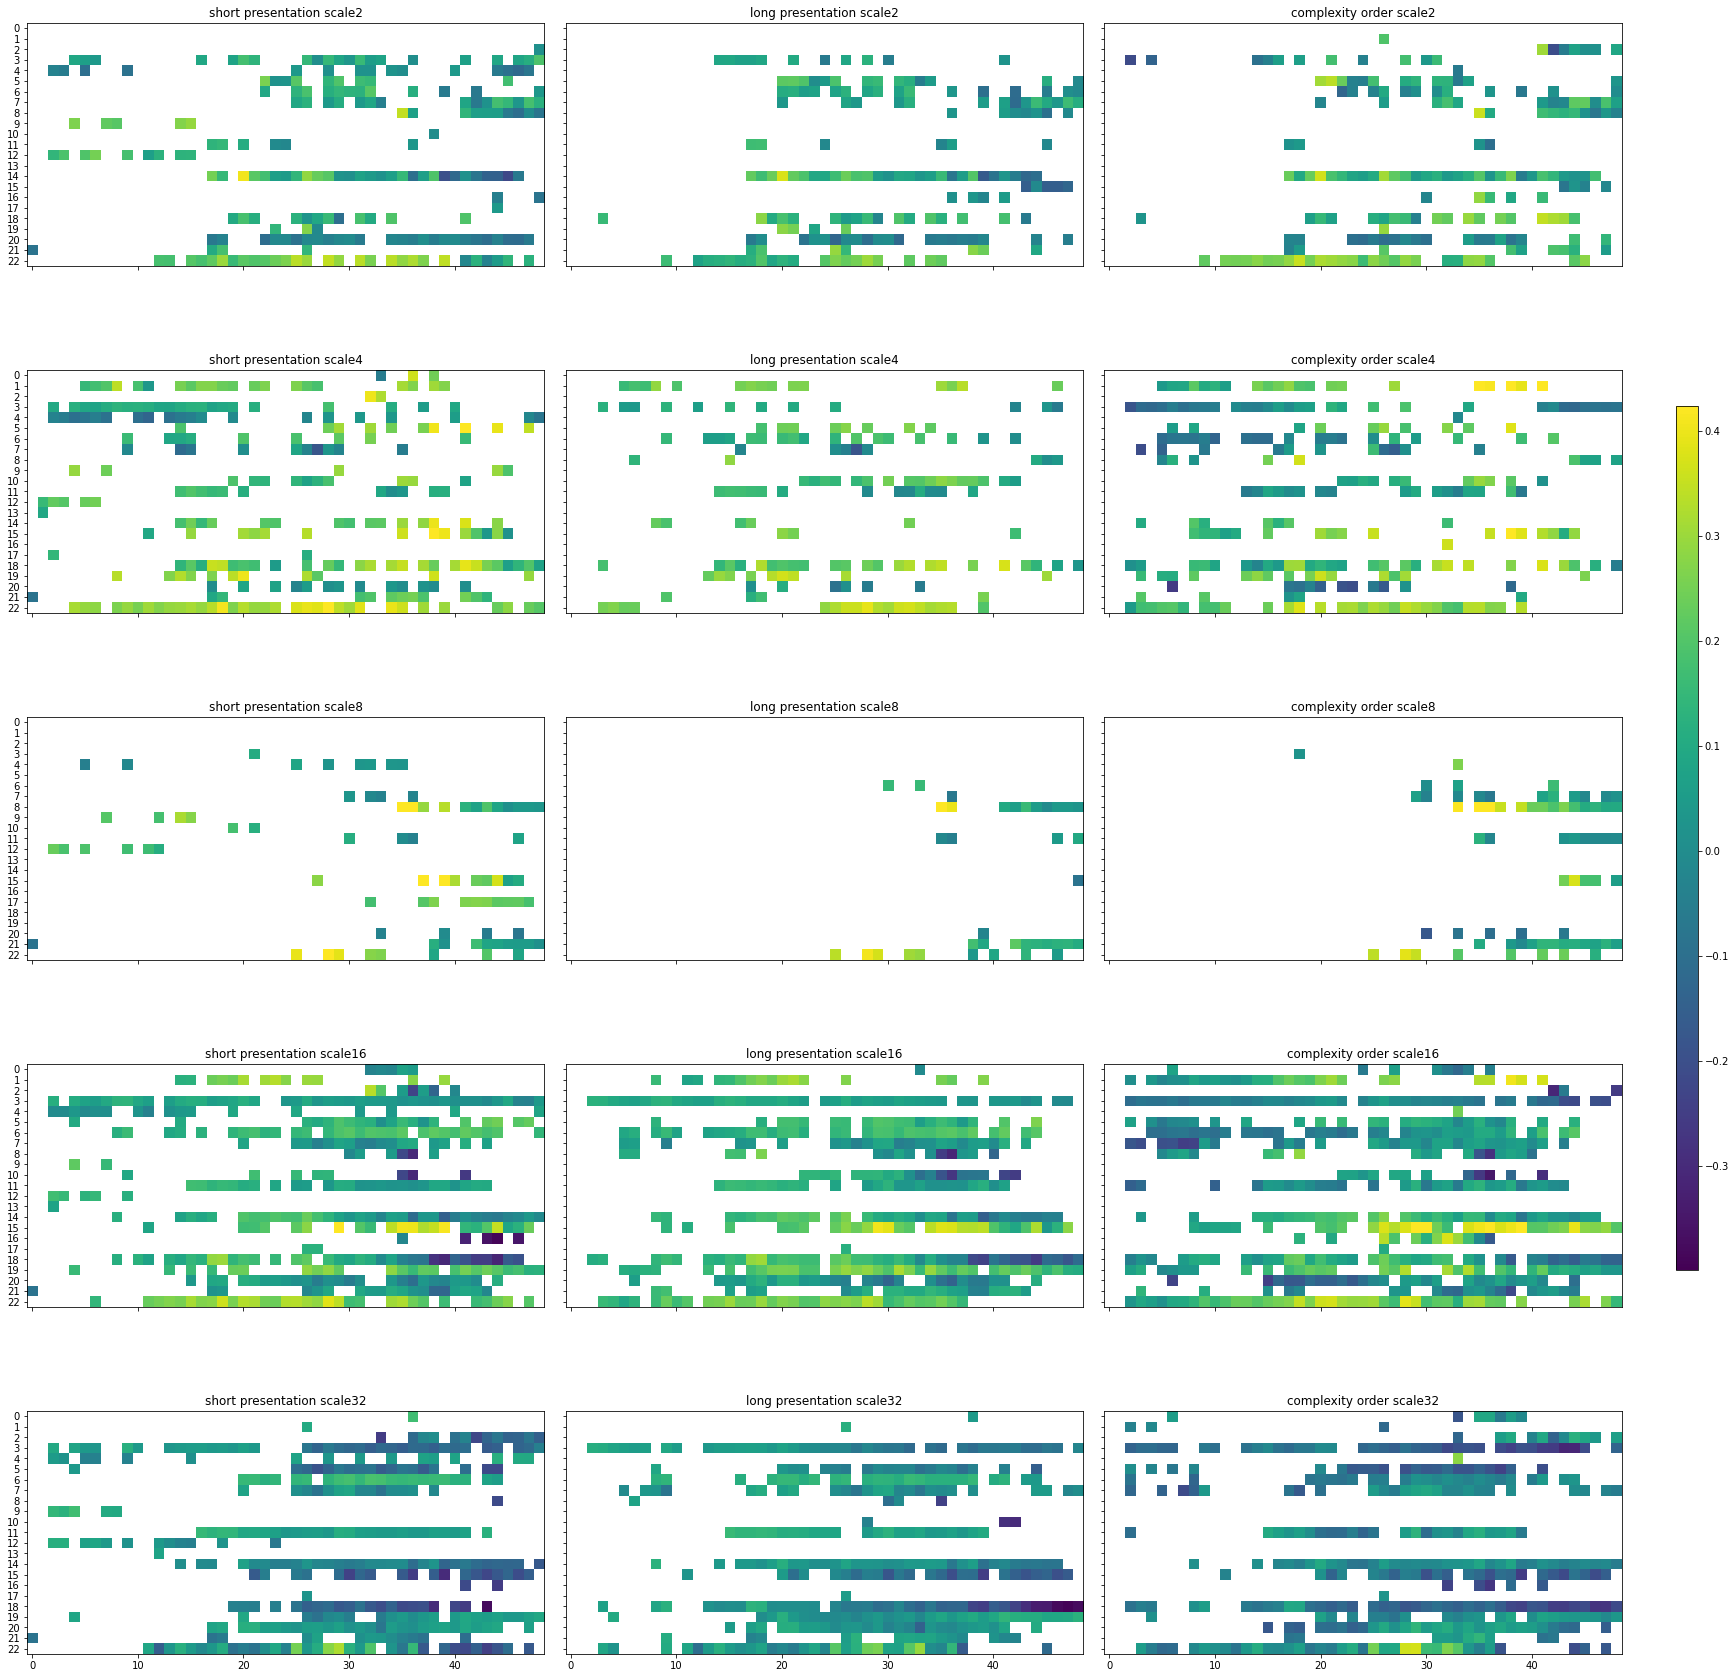

In [736]:
# scale x study grid of all-net heatmaps
fig, axes = plt.subplots(
    5, 3, figsize=(24, 24), sharex=True, sharey=True, constrained_layout=True
)

for idsc, scale in enumerate(SCALE_NAMES):
    for idst, study in enumerate(STUDY_NAMES):
        corr = (
            df_ib_sig.loc[(slice(None), study, scale), :]
            .droplevel(["scale", "study"])
            .iloc[order, :]
        )
        p = df_p.loc[(slice(None), study, scale), :].droplevel(["scale", "study"])

        ax = axes[idsc, idst]
        im = ax.imshow(corr, vmin=df_ib.min().min(), vmax=df_ib.max().max())
        # ax.contour(p, levels=[0.05], colors='orange', linewidths=5, corner_mask = False)

        ax.set_yticks(range(len(corr.index)))
        # ax.set_yticklabels(corr.index)
        ax.set_title(study + " " + scale)

fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.2, pad=0.03, shrink=0.5)
# plt.subplots_adjust(hspace=0.2, wspace=.005)
# plt.tight_layout()

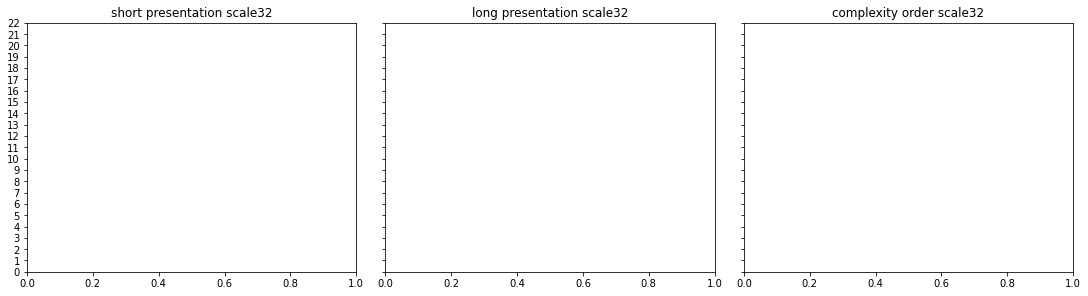

In [405]:
fig, axes = plt.subplots(
    1, 3, figsize=(15, 4), sharex=True, sharey=True, constrained_layout=True
)


for idst, study in enumerate(STUDY_NAMES):
    corr = df_ib.loc[(slice(None), study, "scale16"), :].droplevel(["scale", "study"])
    p = df_p.loc[(slice(None), study, scale), :].droplevel(["scale", "study"])
    ax = axes[idst]

    ax.set_yticks(range(len(corr.index)))
    # ax.set_yticklabels(corr.index)
    ax.set_title(study + " " + scale)

# blocking
for  scale 16

## plot1: show oscillations
explain why blocking

In [ ]:
dfc = dfc.loc[(slice(None), "places1", "scale16"), :].droplevel(["scale", "dataset"])

In [ ]:
df_ib = df_ibcorr.loc[(slice(None), "short presentation", "scale16"), :].droplevel(
    ["scale", "study"]
)

In [43]:
# sort by std of specific layers
df_maxidx = (
    dfc.iloc[:, slice(27, 43 + 1)]
    .std(axis=1)
    .groupby("model")
    .idxmax()
    .apply(lambda tup: tup[1])
)

In [701]:
# sort by std in all layers
df_maxidx = dfc.std(axis=1).groupby("model").idxmax().apply(lambda tup: tup[1])

Text(0.5, 1.0, 'network means')

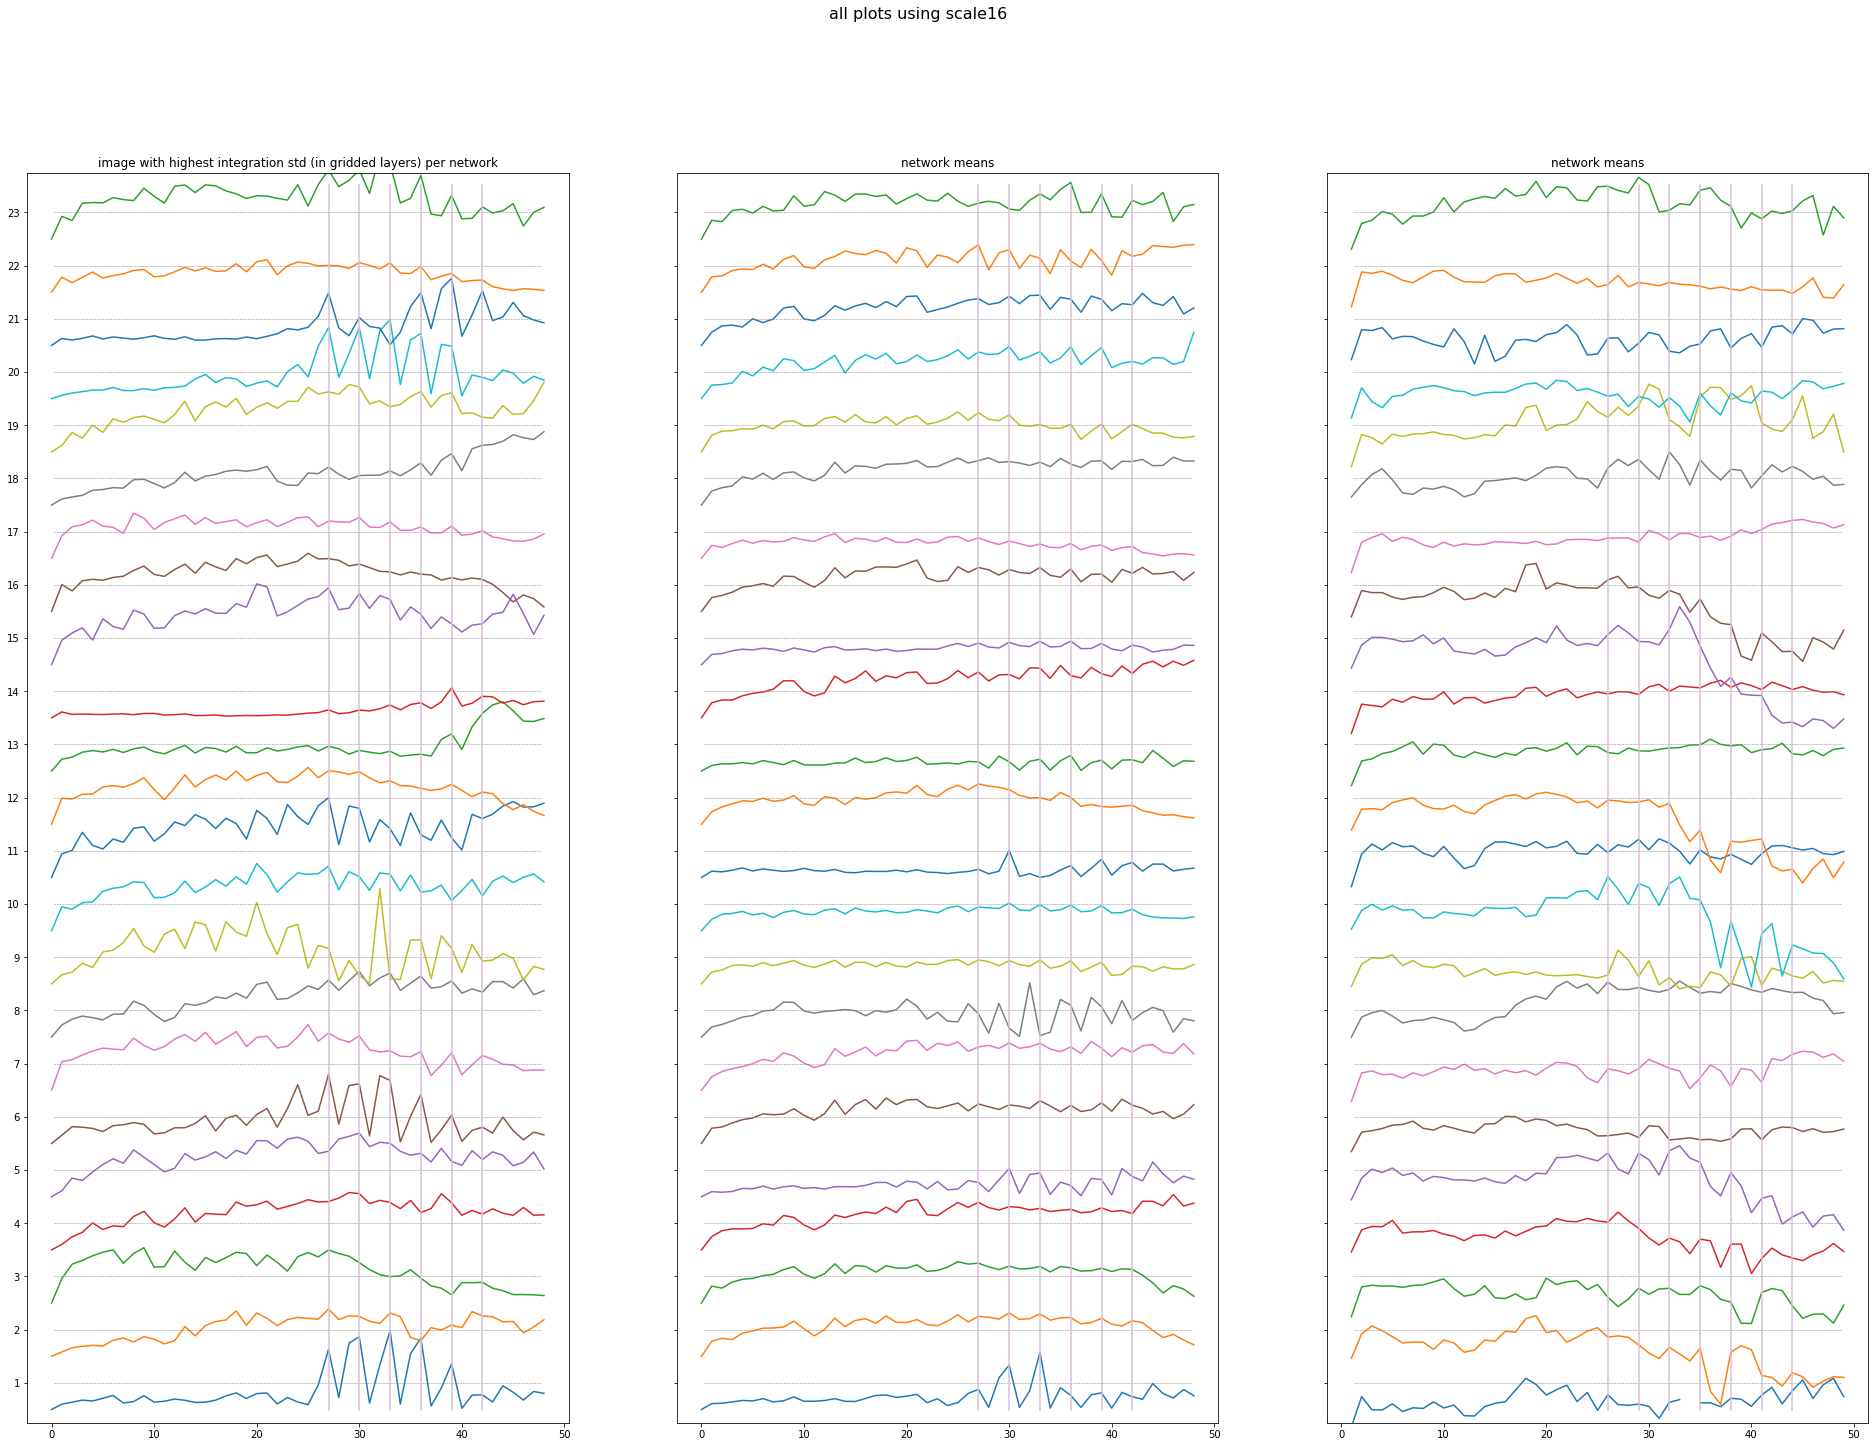

In [46]:
# integration
layers = slice(0, 49)  # first to last layers to plot
yscaling = 3
fig, axes = plt.subplots(1, 3, figsize=(33, 23), sharey=True)
fig.suptitle("all plots using scale16", fontsize=16)


# for idst, study in enumerate(STUDY_NAMES):
#     corr= df_ib.loc[(slice(None),study, 'scale16'),:].droplevel(['scale','study'])
#     p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
#     ax = axes[idst]

#     ax.set_yticks(range(len(corr.index))).rename(columns=lambda x:x+1)
#     #ax.set_yticklabels(corr.index)
#     ax.set_title(study + ' ' + scale)

# individual images
ax = axes[0]

for y, model in enumerate(MODEL_NAMES):
    maxidx = df_maxidx.loc[model]
    data = dfc.loc[(model, maxidx), :].iloc[layers]
    ax.plot(yscaling * data + 2 * y + 3)
    ax.axhline(
        y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95
    )

for layer in range(27, 45, 3):
    ax.axvline(layer, color="thistle", ymin=0.01, ymax=0.99)

ax.set_ylim(0, 23 * 2 + 3)
ax.set_yticks(range(1, 23 * 2, 2))
ax.set_yticklabels(range(1, 23 + 1))
ax.set_title("image with highest integration std (in gridded layers) per network")


# network median
ax = axes[1]
tmp = dfc.groupby("model").median()
for y, model in enumerate(MODEL_NAMES):
    ax.plot(yscaling * tmp.iloc[y, layers] + 2 * y + 3)
    ax.axhline(
        y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95
    )

for layer in range(27, 45, 3):
    ax.axvline(layer, color="thistle", ymin=0.01, ymax=0.99)

ax.set_ylim(-0.5, 23 * 2 + 0.5)
ax.set_yticks(range(1, 23 * 2, 2))
ax.set_yticklabels(range(1, 23 + 1))
ax.set_title("network means")


# ibcorr
ax = axes[2]
for y, model in enumerate(MODEL_NAMES):
    ax.plot(2 * yscaling * df_ib.loc[model] + 2 * y)
    ax.axhline(
        y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5, xmin=0.05, xmax=0.95
    )

for layer in range(26, 45, 3):
    ax.axvline(layer, color="thistle", ymin=0.01, ymax=0.99)

ax.set_ylim(-0.5, 23 * 2 + 0.5)
ax.set_yticks(range(1, 23 * 2, 2))
ax.set_yticklabels(range(1, 23 + 1))
ax.set_title("network means")


# # Add legends, labels, and title
# ax.legend()
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
#

# # Show the plot
# plt.show()
# plt.tight_layout()

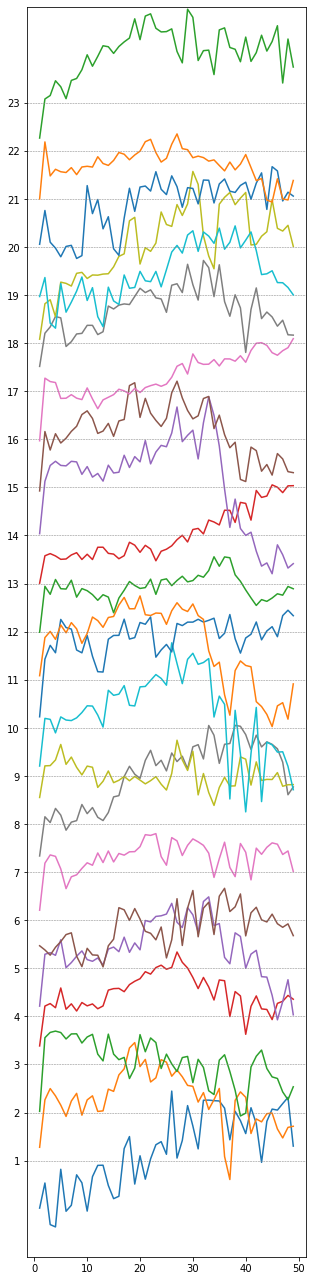

In [489]:
# ibcorr
# unblocked view of scale16

tmp = df_ib.loc[(slice(None), study, "scale16"), :]

fig, ax = plt.subplots(figsize=(5, 23))


# for idst, study in enumerate(STUDY_NAMES):
#     corr= df_ib.loc[(slice(None),study, 'scale16'),:].droplevel(['scale','study'])
#     p   = df_p.loc[(slice(None), study,scale),:].droplevel(['scale','study'])
#     ax = axes[idst]

#     ax.set_yticks(range(len(corr.index)))
#     #ax.set_yticklabels(corr.index)
#     ax.set_title(study + ' ' + scale)

for y, model in enumerate(MODEL_NAMES):
    ax.plot(10 * tmp.iloc[y, slice(None)] + 2 * y + 1)
    ax.axhline(y=2 * y + 1, color="grey", linestyle="--", linewidth=0.5)

ax.set_ylim(-3, 23 * 2 + 3)
ax.set_yticks(range(1, 23 * 2, 2))
ax.set_yticklabels(range(1, 23 + 1))

# Plot each line with its offset
# ax.plot(x, y1, label='sin(x)')
# ax.plot(x, y2_offset, label=f'cos(x) + {offset}')
# ax.plot(x, y3_offset, label=f'exp(x/10) + {2 * offset}')

# # Optionally, add horizontal lines to indicate the offset
# ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=offset, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=2 * offset, color='grey', linestyle='--', linewidth=0.5)

# # Add legends, labels, and title
# ax.legend()
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_title('Multiple Lines with Y-Offset')

# # Show the plot
# plt.show()

## plot2.1: inside block layer structure of oscillations
resnet50 architecture explained before

## plot2.2: ibcorr difference from blocking

In [7]:
df1 = (
    df_ibcorr.loc[(slice(None), "short presentation", "scale16"), :]
    .droplevel(["study", "scale"])
    .fillna(0)
)
df2 = (
    df_ibcorr_b_ubi.loc[(slice(None), "short presentation", "scale16"), :]
    .droplevel(["study", "scale"])
    .fillna(0)
)
df3 = (
    df_ibcorr_b_bi.loc[(slice(None), "short presentation", "scale16"), :]
    .droplevel(["study", "scale"])
    .fillna(0)
)
df4 = (
    dfi.loc[(slice(None), "places1", "scale16"), :]
    .droplevel(["dataset", "scale"])
    .fillna(0)
)
df5 = (
    dfi_b.loc[(slice(None), "places1", "scale16"), :]
    .droplevel(["dataset", "scale"])
    .fillna(0)
)

In [8]:
# calculate where there's significant difference between blocked and unblocked

# per-block check for significant difference between:
#   ib-correlation from best predicting unblocked integration
#   average integration of block


def compare_corr(r_yx1, r_yx2, X1, X2, correlation="pearson") -> float:
    """Compares two correlation coefficients that are non-independent because they're based on the same sample
    and returns a Z-statistic to perform a hypothesis test.

    This method is described in Meng, Rosenthal, Rubin; 1992; Psych. Bulletin

    """
    if correlation == "pearson":
        rx = pearsonr(X1, X2)[0]
    elif correlation == "spearman":
        rx = spearmanr(X1, X2)[0]

    r2bar = (r_yx1**2 + r_yx2**2) / 2
    f = (1 - rx) / (2 * (1 - r2bar))
    h = (1 - f * r2bar) / (1 - r2bar)
    N = len(X1)

    # fisher z-transform
    z_yx1, z_yx2 = np.arctanh(r_yx1), np.arctanh(r_yx2)

    Z = (z_yx1 - z_yx2) * np.sqrt((N - 3) / (2 * rx * h))

    return Z


def models_best_predicting_integration_from_block(
    block_num: int,
    df_model_ibcorr: pd.Series,
    df_model_integration,
    block_layer_mapping=BLOCKING_GROUPS,
):
    """Returns layer num (nums starting with 0) from a block.

    ---
    block_num: equals the layer num in the blocked layers

    """
    mask = block_layer_mapping == block_num
    idx = df_model_ibcorr[mask].idxmax()
    return df_model_integration[idx]


df_s = pd.DataFrame(index=MODEL_NAMES, columns=df3.columns)
for mo in MODEL_NAMES:
    for layer in df3.columns:
        df_s.loc[mo, layer] = compare_corr(
            r_yx1=df2.loc[mo, layer],
            r_yx2=df3.loc[mo, layer],
            X1=models_best_predicting_integration_from_block(
                layer, df1.loc[mo], df4.loc[mo]
            ),
            X2=df5.loc[(mo, slice(None)), layer],
        )

from scipy.stats import norm

alpha_mcc = (0.05 / 17) / 2
(df_s > norm.ppf(1 - alpha_mcc / 2)).sum().sum(), (
    df_s < norm.ppf(alpha_mcc / 2)
).sum().sum()

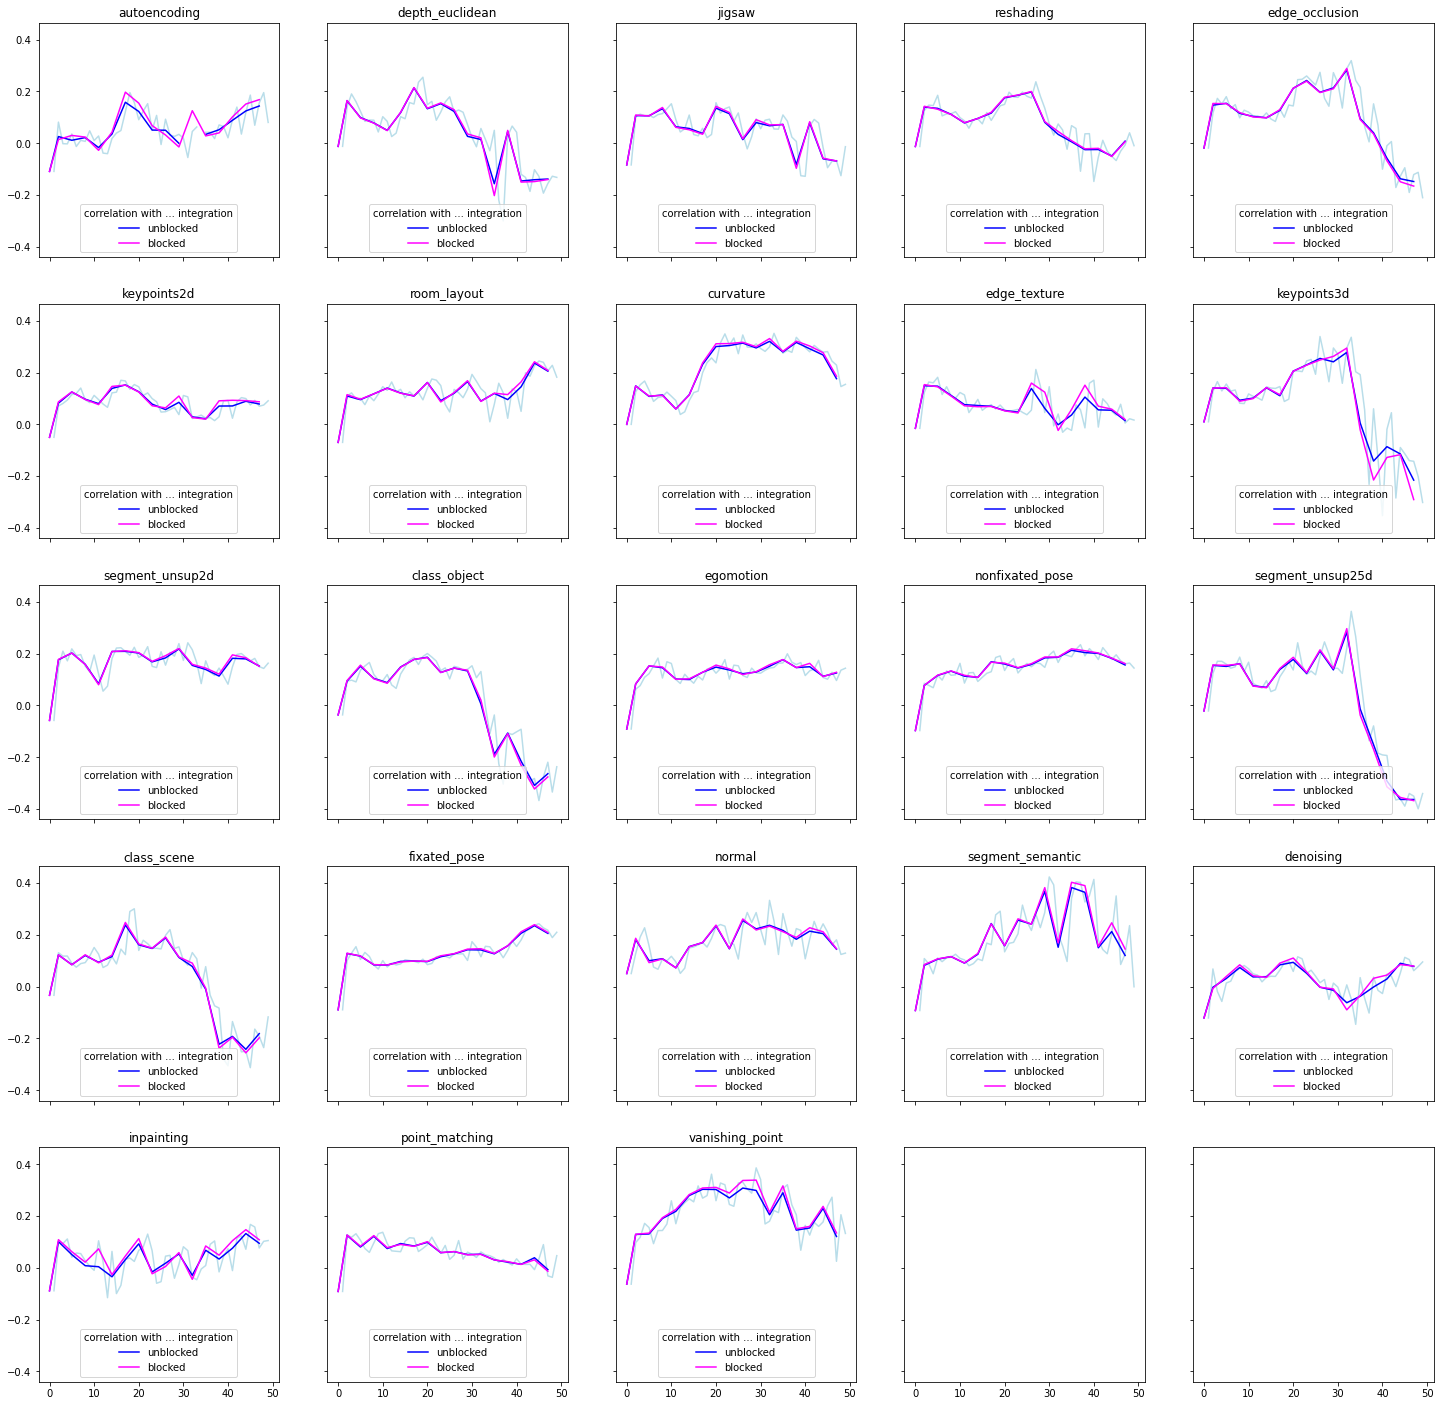

In [136]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25), sharex=True, sharey=True)

# plot the blocked value in the middle index of the unblocked values, eg 2, 2, 3, ->3<-, 3, 4, 4, ...
block_plot_indices = [0] + list(range(2, 49, 3))
block_plot_indices

for ax, mo in zip(axes.flat, MODEL_NAMES):

    ax.plot(df1.loc[mo], alpha=0.85, c="lightblue")
    ax.set_title(mo)
    ax.plot(block_plot_indices, df2.loc[mo], label="unblocked", c="blue")
    ax.plot(block_plot_indices, df3.loc[mo], label="blocked", c="magenta")
    ax.legend(title="correlation with ... integration", loc="lower center")

# test: heatmap significance

In [145]:
data = np.pad(np.random.random((10, 10)), 1)
data.shape

(12, 12)

In [180]:
data = np.random.random((10, 10))

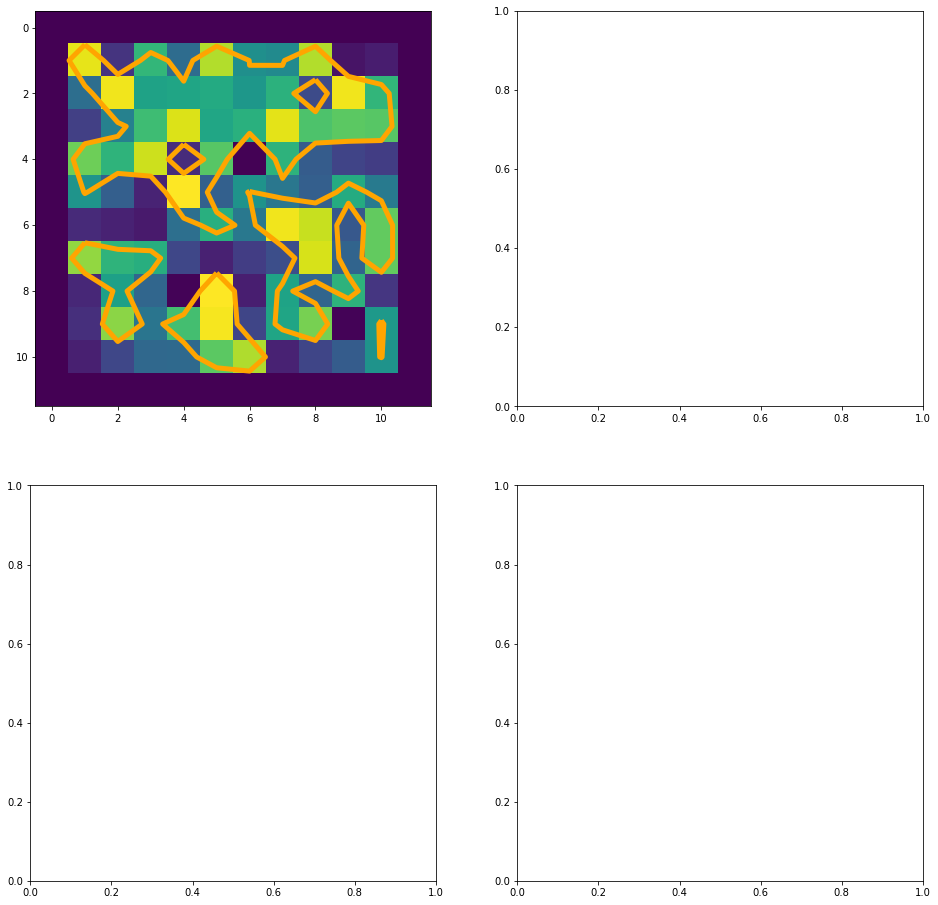

In [209]:
# data = np.pad(np.random.random((10, 10)), 1)
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Example significance mask (True for significant, False for not)
# Let's assume that any value greater than 0.8 is significant
significance_mask = data > 0.8

# Plotting the heatmap
ax[0, 0].imshow(data, cmap="viridis")

# Overlay the contours for significance
ax[0, 0].contour(data, levels=[0.5], colors="orange", linewidths=5, corner_mask=False)

# Add colorbar
# plt.colorbar()

# Show the plot
plt.show()